In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-14/age_gaps.csv"
age_gaps = pd.read_csv(url)

age_gaps.columns = age_gaps.columns.str.lower()

# parse dates
date_cols = [c for c in age_gaps.columns if "birthdate" in c]
for c in date_cols:
    age_gaps[c] = pd.to_datetime(age_gaps[c], errors="coerce")

age_gaps.info()
age_gaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_name          1155 non-null   object        
 1   release_year        1155 non-null   int64         
 2   director            1155 non-null   object        
 3   age_difference      1155 non-null   int64         
 4   couple_number       1155 non-null   int64         
 5   actor_1_name        1155 non-null   object        
 6   actor_2_name        1155 non-null   object        
 7   character_1_gender  1155 non-null   object        
 8   character_2_gender  1155 non-null   object        
 9   actor_1_birthdate   1155 non-null   datetime64[ns]
 10  actor_2_birthdate   1155 non-null   datetime64[ns]
 11  actor_1_age         1155 non-null   int64         
 12  actor_2_age         1155 non-null   int64         
dtypes: datetime64[ns](2), int64(5), object(6)
memory

,movie_name,release_year,director,age_difference,couple_number,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_birthdate,actor_2_birthdate,actor_1_age,actor_2_age
0,Harold and Maude,1971,Hal Ashby,52,1,Ruth Gordon,Bud Cort,woman,man,1896-10-30,1948-03-29,75,23
1,Venus,2006,Roger Michell,50,1,Peter O'Toole,Jodie Whittaker,man,woman,1932-08-02,1982-06-03,74,24
2,The Quiet American,2002,Phillip Noyce,49,1,Michael Caine,Do Thi Hai Yen,man,woman,1933-03-14,1982-10-01,69,20
3,The Big Lebowski,1998,Joel Coen,45,1,David Huddleston,Tara Reid,man,woman,1930-09-17,1975-11-08,68,23
4,Beginners,2010,Mike Mills,43,1,Christopher Plummer,Goran Visnjic,man,man,1929-12-13,1972-09-09,81,38


# Data processing

Check missing value

In [ ]:
age_gaps.isna().sum()

,0
movie_name,0
release_year,0
director,0
age_difference,0
couple_number,0
actor_1_name,0
actor_2_name,0
character_1_gender,0
character_2_gender,0
actor_1_birthdate,0


Drop useless column

In [ ]:
age_gaps_copy = age_gaps.copy()
age_gaps_copy=age_gaps_copy.drop(columns=['actor_1_birthdate', 'actor_2_birthdate', 'couple_number'])

# Feature Engineering

Add new features

In [ ]:
#Add new feature: actor frequency
actors = pd.concat([age_gaps_copy["actor_1_name"], age_gaps_copy["actor_2_name"]]).dropna()
actor_counts = actors.value_counts()

age_gaps_copy["actor_1_freq"] = age_gaps_copy["actor_1_name"].map(actor_counts).fillna(0)
age_gaps_copy["actor_2_freq"] = age_gaps_copy["actor_2_name"].map(actor_counts).fillna(0)

age_gaps_copy["actor_freq_sum"] = (
    age_gaps_copy["actor_1_freq"] + age_gaps_copy["actor_2_freq"]
)

# add new feature: director frequency
director_col = "director"
director_counts = age_gaps_copy[director_col].value_counts()

age_gaps_copy["director_freq"] = (
    age_gaps_copy[director_col].map(director_counts).fillna(0)
)

#Add new feature: younger_age
age_gaps_copy['younger_age'] = age_gaps_copy[['actor_1_age', 'actor_2_age']].min(axis=1)

#Add new feature: older_age
age_gaps_copy['order_age'] = age_gaps_copy[['actor_1_age', 'actor_2_age']].max(axis=1)

#Add new feature: mean_age_of_couple
age_gaps_copy['mean_age_of_couple'] = (age_gaps_copy['younger_age'] + age_gaps_copy['order_age'])/2

# add new column named " relative_age_gap"
age_gaps_copy['relative_age_gap'] = age_gaps_copy['age_difference']/age_gaps_copy['younger_age']

#Add new feature: relationship_type
age_gaps_copy["relationship_type"] = np.where(
    age_gaps_copy["character_1_gender"] == age_gaps_copy["character_2_gender"],
    "Same-gender",
    "Heterosexual"
)

#Add new feature: who_is_older
age_gaps_copy["who_is_older"] = np.where(
    age_gaps_copy["relationship_type"] != "Heterosexual",
   "Same-gender",
    np.where(
        age_gaps_copy["actor_1_age"] > age_gaps_copy["actor_2_age"],
        age_gaps_copy["character_1_gender"],
        np.where(
            age_gaps_copy["actor_2_age"] > age_gaps_copy["actor_1_age"],
            age_gaps_copy["character_2_gender"],
            "same_age"
        )
    )
)

#Add new feature: by_decade
age_gaps_copy["by_decade"] = (age_gaps_copy["release_year"] // 10) * 10


In [ ]:
age_gaps_copy.head()

,movie_name,release_year,director,age_difference,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_age,actor_2_age,...,actor_2_freq,actor_freq_sum,director_freq,younger_age,order_age,mean_age_of_couple,relative_age_gap,relationship_type,who_is_older,by_decade
0,Harold and Maude,1971,Hal Ashby,52,Ruth Gordon,Bud Cort,woman,man,75,23,...,1,2,1,23,75,49.0,2.260870,Heterosexual,woman,1970
1,Venus,2006,Roger Michell,50,Peter O'Toole,Jodie Whittaker,man,woman,74,24,...,1,2,3,24,74,49.0,2.083333,Heterosexual,man,2000
2,The Quiet American,2002,Phillip Noyce,49,Michael Caine,Do Thi Hai Yen,man,woman,69,20,...,2,3,2,20,69,44.5,2.450000,Heterosexual,man,2000
3,The Big Lebowski,1998,Joel Coen,45,David Huddleston,Tara Reid,man,woman,68,23,...,2,3,5,23,68,45.5,1.956522,Heterosexual,man,1990
4,Beginners,2010,Mike Mills,43,Christopher Plummer,Goran Visnjic,man,man,81,38,...,1,3,2,38,81,59.5,1.131579,Same-gender,Same-gender,2010


In [ ]:
age_gaps_copy.columns

Index(['movie_name', 'release_year', 'director', 'age_difference',
       'actor_1_name', 'actor_2_name', 'character_1_gender',
       'character_2_gender', 'actor_1_age', 'actor_2_age', 'actor_1_freq',
       'actor_2_freq', 'actor_freq_sum', 'director_freq', 'younger_age',
       'order_age', 'mean_age_of_couple', 'relative_age_gap',
       'relationship_type', 'who_is_older', 'by_decade'],
      dtype='object')

#Feature Normalization

In [ ]:
#build cluster matrix
cluster_df = age_gaps_copy[[
    "age_difference",
    "mean_age_of_couple",
    "relative_age_gap",
    "actor_1_age",
    "actor_2_age",
    "actor_freq_sum",
    "director_freq",
    "release_year"
]]
cluster_df

,age_difference,mean_age_of_couple,relative_age_gap,actor_1_age,actor_2_age,actor_freq_sum,director_freq,release_year
0,52,49.0,2.260870,75,23,2,1,1971
1,50,49.0,2.083333,74,24,2,3,2006
2,49,44.5,2.450000,69,20,3,2,2002
3,45,45.5,1.956522,68,23,3,5,1998
4,43,59.5,1.131579,81,38,3,2,2010
...,...,...,...,...,...,...,...,...
1150,0,23.0,0.000000,23,23,12,4,2013
1151,0,42.0,0.000000,42,42,34,1,2006
1152,0,30.0,0.000000,30,30,5,1,2019
1153,0,21.0,0.000000,21,21,3,6,2007


Standardization(StandardScaler)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# Normalize df
df_normalized = pd.DataFrame(sc.fit_transform(cluster_df), columns=cluster_df.columns)

df_normalized

,age_difference,mean_age_of_couple,relative_age_gap,actor_1_age,actor_2_age,actor_freq_sum,director_freq,release_year
0,4.887011,1.693628,5.471972,3.298045,-0.962437,-1.183765,-0.867634,-1.821604
1,4.651921,1.693628,4.956601,3.202072,-0.828974,-1.183765,-0.313059,0.317926
2,4.534377,1.132271,6.020999,2.722210,-1.362826,-1.031102,-0.590346,0.073408
3,4.064198,1.257017,4.588479,2.626238,-0.962437,-1.031102,0.241516,-0.171109
4,3.829108,3.003460,2.193749,3.873879,1.039510,-1.031102,-0.590346,0.562444
...,...,...,...,...,...,...,...,...
1150,-1.225315,-1.549765,-1.091117,-1.692522,-0.962437,0.342864,-0.035771,0.745832
1151,-1.225315,0.820407,-1.091117,0.130955,1.573363,3.701446,-0.867634,0.317926
1152,-1.225315,-0.676544,-1.091117,-1.020715,-0.028195,-0.725776,-0.867634,1.112609
1153,-1.225315,-1.799257,-1.091117,-1.884466,-1.229363,-1.031102,0.518804,0.379055


# K-Means

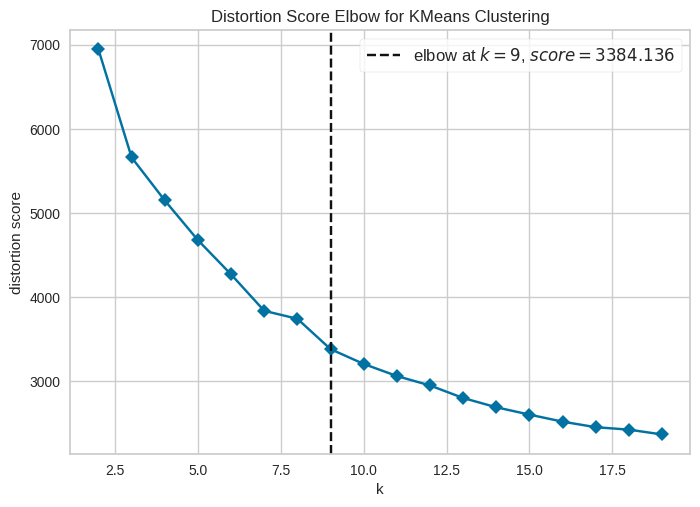

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='distortion', timings=False, random_state=42  #metric='silhouette' metric='distortion'
)

visualizer.fit(df_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

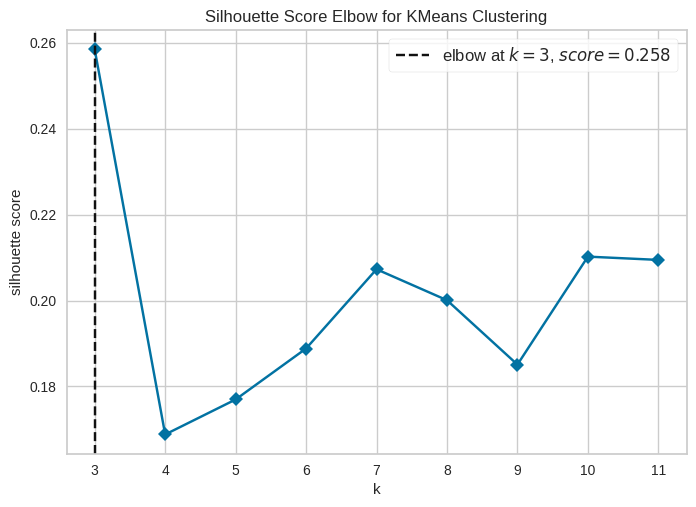

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(3, 12), metric='silhouette', timings=False, random_state=42  #metric='silhouette' metric='distortion'
)

visualizer.fit(df_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
#Check number of data point in each cluster
from sklearn.cluster import KMeans

for k in [3,4,5,6,7]:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_normalized)
    print("k =", k)
    print(pd.Series(labels).value_counts(), "\n")

k = 3
0    643
1    259
2    253
Name: count, dtype: int64 

k = 4
1    412
0    338
2    246
3    159
Name: count, dtype: int64 

k = 5
1    353
0    302
2    201
4    162
3    137
Name: count, dtype: int64 

k = 6
1    331
0    285
5    203
4    157
3    140
2     39
Name: count, dtype: int64 

k = 7
1    304
0    292
5    173
4    145
3    119
6     83
2     39
Name: count, dtype: int64 



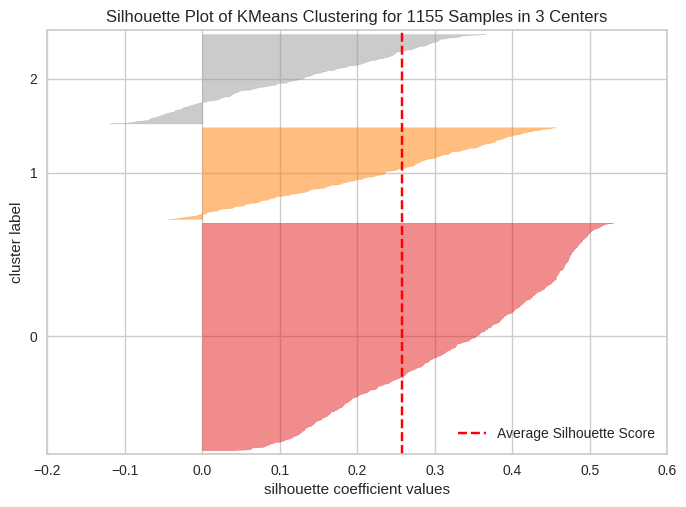

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1155 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
n_clusters_kmeans=3

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(df_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
age_gap_copy_fail = age_gaps_copy.copy()
age_gap_copy_fail

,movie_name,release_year,director,age_difference,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_age,actor_2_age,...,actor_2_freq,actor_freq_sum,director_freq,younger_age,order_age,mean_age_of_couple,relative_age_gap,relationship_type,who_is_older,by_decade
0,Harold and Maude,1971,Hal Ashby,52,Ruth Gordon,Bud Cort,woman,man,75,23,...,1,2,1,23,75,49.0,2.260870,Heterosexual,woman,1970
1,Venus,2006,Roger Michell,50,Peter O'Toole,Jodie Whittaker,man,woman,74,24,...,1,2,3,24,74,49.0,2.083333,Heterosexual,man,2000
2,The Quiet American,2002,Phillip Noyce,49,Michael Caine,Do Thi Hai Yen,man,woman,69,20,...,2,3,2,20,69,44.5,2.450000,Heterosexual,man,2000
3,The Big Lebowski,1998,Joel Coen,45,David Huddleston,Tara Reid,man,woman,68,23,...,2,3,5,23,68,45.5,1.956522,Heterosexual,man,1990
4,Beginners,2010,Mike Mills,43,Christopher Plummer,Goran Visnjic,man,man,81,38,...,1,3,2,38,81,59.5,1.131579,Same-gender,Same-gender,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,The Hunger Games: Catching Fire,2013,Francis Lawrence,0,Liam Hemsworth,Jennifer Lawrence,man,woman,23,23,...,10,12,4,23,23,23.0,0.000000,Heterosexual,same_age,2010
1151,The Lake House,2006,Alejandro Agresti,0,Sandra Bullock,Keanu Reeves,woman,man,42,42,...,27,34,1,42,42,42.0,0.000000,Heterosexual,same_age,2000
1152,Tolkien,2019,Dome Karukoski,0,Lily Collins,Nicholas Hoult,woman,man,30,30,...,3,5,1,30,30,30.0,0.000000,Heterosexual,same_age,2010
1153,Transformers,2007,Michael Bay,0,Megan Fox,Shia LaBeouf,woman,man,21,21,...,2,3,6,21,21,21.0,0.000000,Heterosexual,same_age,2000


In [ ]:
# build final kmeans model (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)

age_gap_copy_fail["cluster"] = kmeans.fit_predict(df_normalized)

In [ ]:
age_gap_copy_fail.groupby('cluster')['age_difference'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,643.0,5.998445,4.052805,0.0,3.0,5.0,9.0,16.0
1,259.0,9.177606,5.854115,0.0,4.0,8.0,13.0,32.0
2,253.0,22.948617,6.762505,11.0,18.0,21.0,26.0,52.0


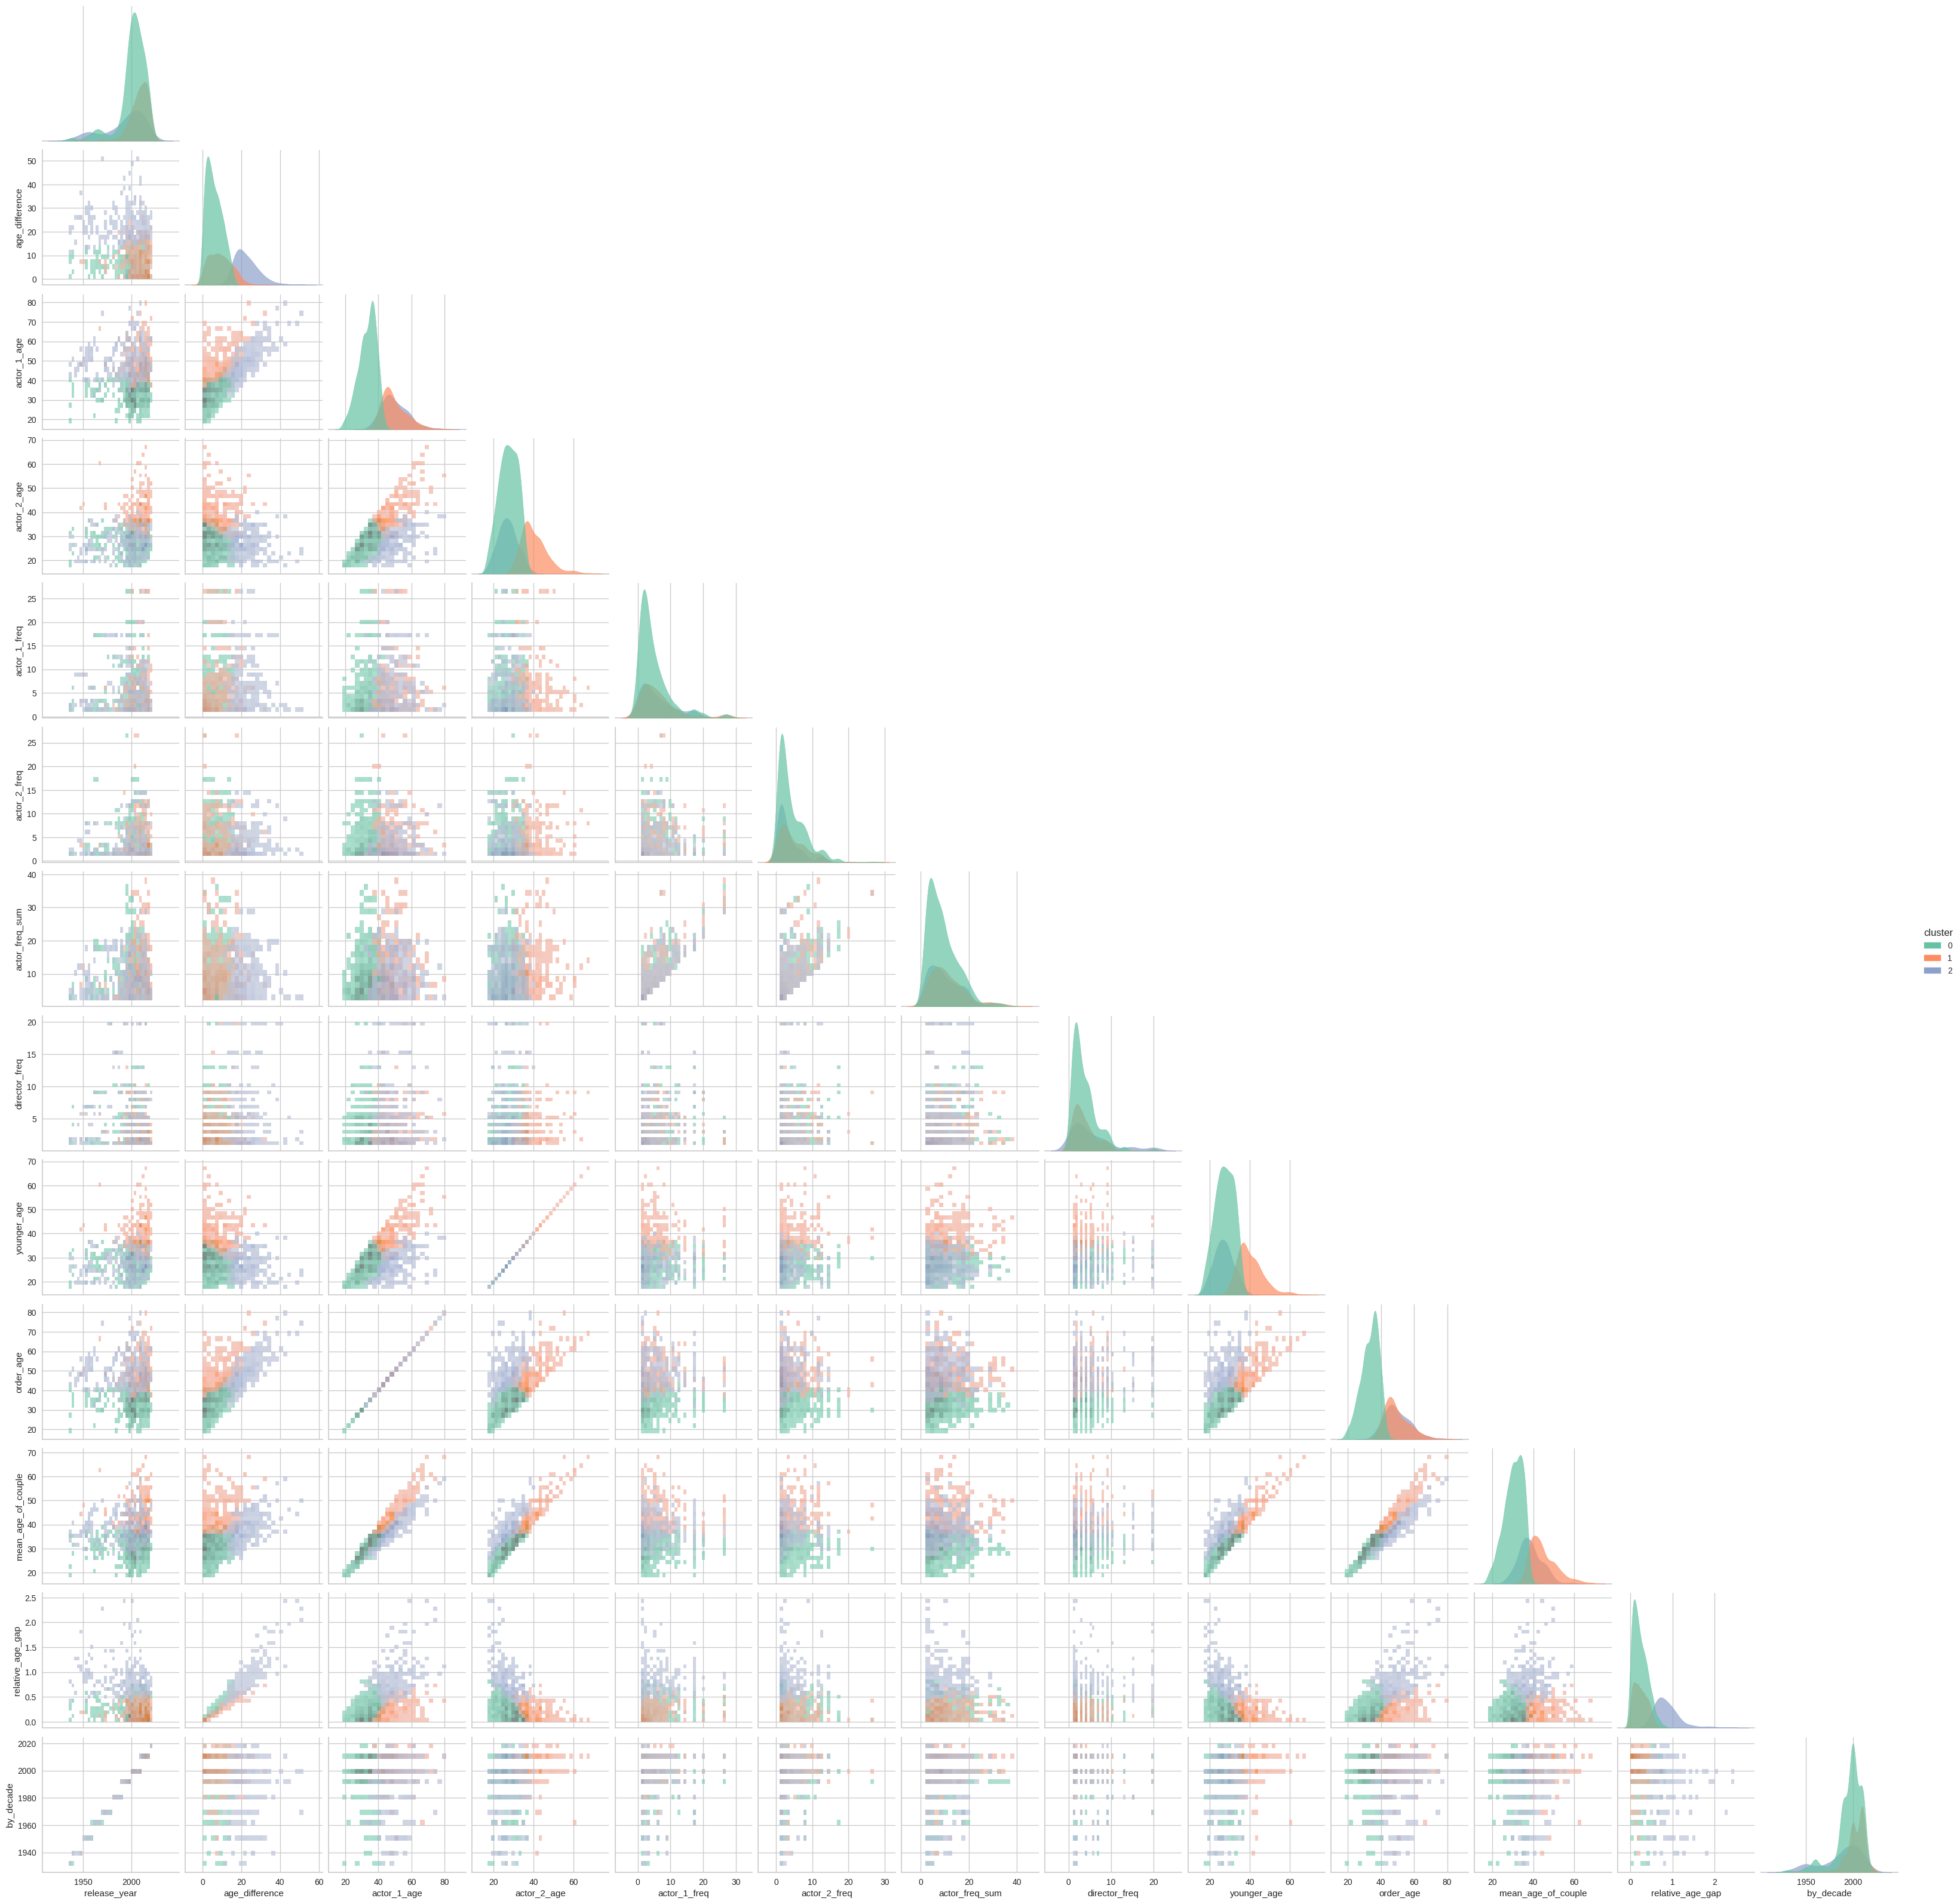

In [ ]:
import seaborn as sns

sns.pairplot(age_gap_copy_fail, hue="cluster", kind="hist", diag_kind="kde", corner=True, palette="Set2",
    plot_kws={'alpha': 0.7}, # Adjusts transparency of the scatter points (0.0 to 1.0)
    diag_kws={'alpha': 0.7}  # Adjusts transparency of the diagonal plots (histograms/KDEs)
    )

In [ ]:
age_gap_copy_fail.groupby('cluster')['age_difference'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,643.0,5.998445,4.052805,0.0,3.0,5.0,9.0,16.0
1,259.0,9.177606,5.854115,0.0,4.0,8.0,13.0,32.0
2,253.0,22.948617,6.762505,11.0,18.0,21.0,26.0,52.0


# Model 0: Baseline Model (all non-textual features)

In [ ]:
#build cluster matrix
dir_cluster_model0 = age_gaps_copy[[
    "age_difference",
    "mean_age_of_couple",
    "relative_age_gap"
]]
dir_cluster_model0

,age_difference,mean_age_of_couple,relative_age_gap
0,52,49.0,2.260870
1,50,49.0,2.083333
2,49,44.5,2.450000
3,45,45.5,1.956522
4,43,59.5,1.131579
...,...,...,...
1150,0,23.0,0.000000
1151,0,42.0,0.000000
1152,0,30.0,0.000000
1153,0,21.0,0.000000


In [ ]:
dir_model0_normalized = pd.DataFrame(sc.fit_transform(dir_cluster_model0), columns=dir_cluster_model0.columns)

dir_model0_normalized

,age_difference,mean_age_of_couple,relative_age_gap
0,4.887011,1.693628,5.471972
1,4.651921,1.693628,4.956601
2,4.534377,1.132271,6.020999
3,4.064198,1.257017,4.588479
4,3.829108,3.003460,2.193749
...,...,...,...
1150,-1.225315,-1.549765,-1.091117
1151,-1.225315,0.820407,-1.091117
1152,-1.225315,-0.676544,-1.091117
1153,-1.225315,-1.799257,-1.091117


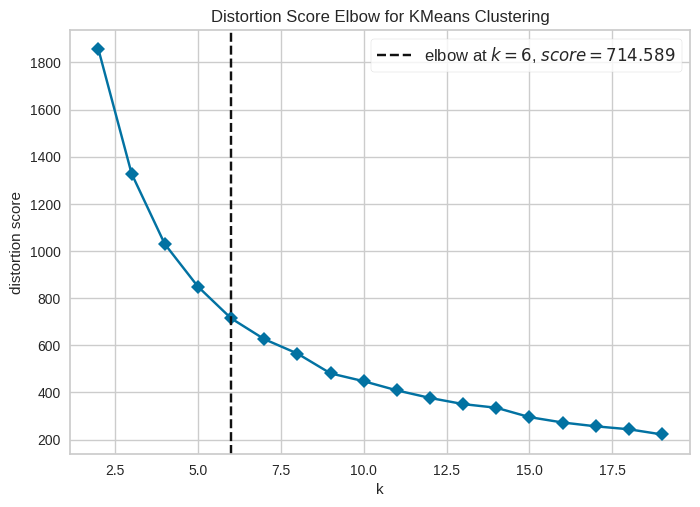

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='distortion', timings=False, random_state=42
)

visualizer.fit(dir_model0_normalized)
visualizer.show()

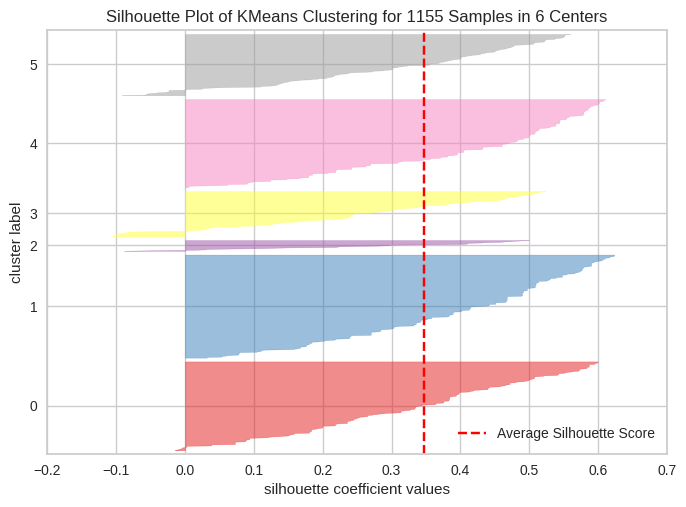

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1155 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
n_clusters_kmeans=6

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(dir_model0_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

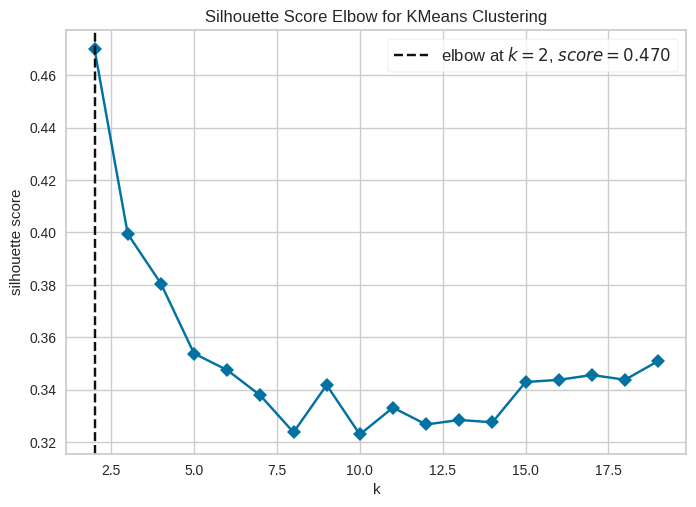

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='silhouette', timings=False, random_state=42
)

visualizer.fit(dir_model0_normalized)
visualizer.show()

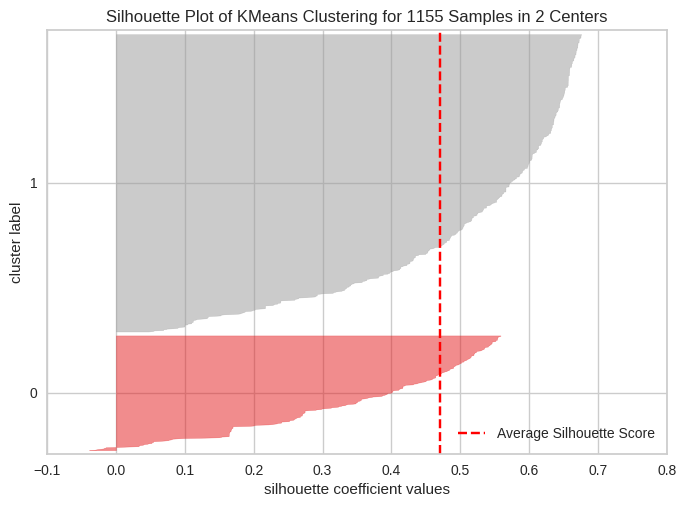

Average silhouette score: 0.4697771528619048


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
n_clusters_kmeans=2

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(dir_model0_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

print("Average silhouette score:", visualizer.silhouette_score_)

# Model 1: Non-textual features + Actor Frequency


In [ ]:
#build cluster matrix
dir_cluster_model1 = age_gaps_copy[[
    "age_difference",
    "mean_age_of_couple",
    "relative_age_gap",
    "actor_freq_sum"
]]
dir_cluster_model1

,age_difference,mean_age_of_couple,relative_age_gap,actor_freq_sum
0,52,49.0,2.260870,2
1,50,49.0,2.083333,2
2,49,44.5,2.450000,3
3,45,45.5,1.956522,3
4,43,59.5,1.131579,3
...,...,...,...,...
1150,0,23.0,0.000000,12
1151,0,42.0,0.000000,34
1152,0,30.0,0.000000,5
1153,0,21.0,0.000000,3


In [ ]:
dir_model1_normalized = pd.DataFrame(sc.fit_transform(dir_cluster_model1), columns=dir_cluster_model1.columns)

dir_model1_normalized

,age_difference,mean_age_of_couple,relative_age_gap,actor_freq_sum
0,4.887011,1.693628,5.471972,-1.183765
1,4.651921,1.693628,4.956601,-1.183765
2,4.534377,1.132271,6.020999,-1.031102
3,4.064198,1.257017,4.588479,-1.031102
4,3.829108,3.003460,2.193749,-1.031102
...,...,...,...,...
1150,-1.225315,-1.549765,-1.091117,0.342864
1151,-1.225315,0.820407,-1.091117,3.701446
1152,-1.225315,-0.676544,-1.091117,-0.725776
1153,-1.225315,-1.799257,-1.091117,-1.031102


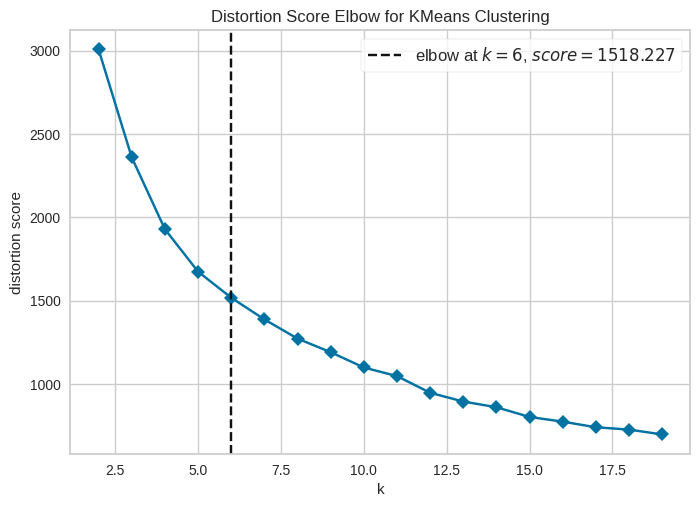

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='distortion', timings=False, random_state=42
)

visualizer.fit(dir_model1_normalized)
visualizer.show()

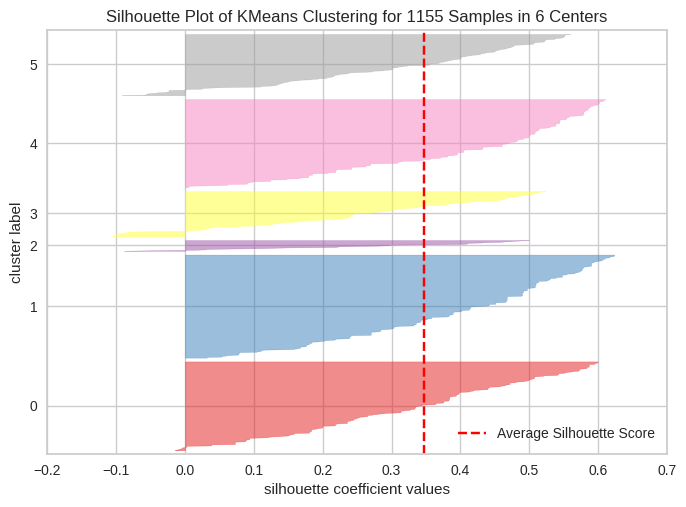

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1155 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
n_clusters_kmeans=6

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(dir_model0_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

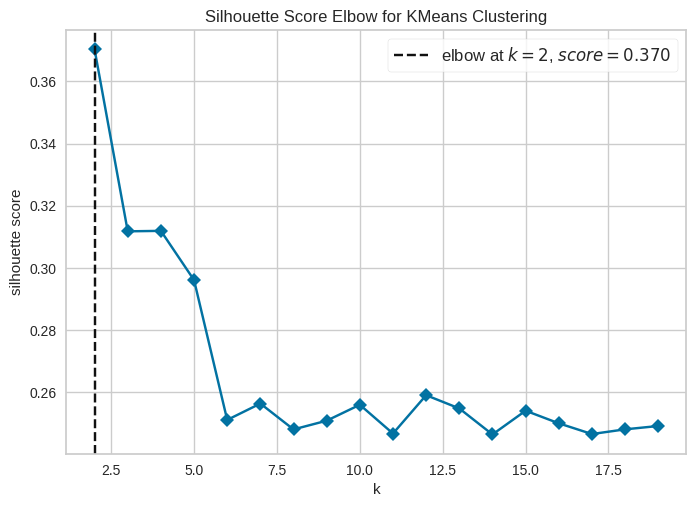

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='silhouette', timings=False, random_state=42
)

visualizer.fit(dir_model1_normalized)
visualizer.show()

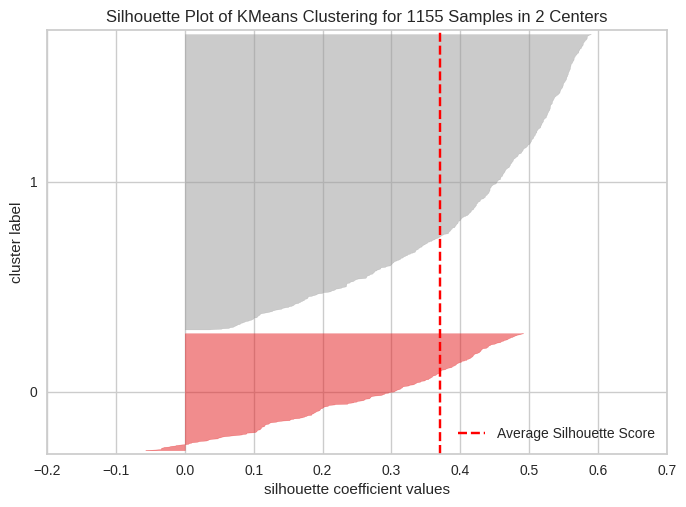

Average silhouette score: 0.3702330606455822


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
n_clusters_kmeans=2

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(dir_model1_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
print("Average silhouette score:", visualizer.silhouette_score_)

# Model 2: Non-textual features + Director Frequency

In [ ]:
#build cluster matrix
dir_cluster_model2 = age_gaps_copy[[
    "age_difference",
    "mean_age_of_couple",
    "relative_age_gap",
    "director_freq"
]]
dir_cluster_model2

,age_difference,mean_age_of_couple,relative_age_gap,director_freq
0,52,49.0,2.260870,1
1,50,49.0,2.083333,3
2,49,44.5,2.450000,2
3,45,45.5,1.956522,5
4,43,59.5,1.131579,2
...,...,...,...,...
1150,0,23.0,0.000000,4
1151,0,42.0,0.000000,1
1152,0,30.0,0.000000,1
1153,0,21.0,0.000000,6


In [ ]:
# Normalize df
dir_model2_normalized = pd.DataFrame(sc.fit_transform(dir_cluster_model2), columns=dir_cluster_model2.columns)

dir_model2_normalized

,age_difference,mean_age_of_couple,relative_age_gap,director_freq
0,4.887011,1.693628,5.471972,-0.867634
1,4.651921,1.693628,4.956601,-0.313059
2,4.534377,1.132271,6.020999,-0.590346
3,4.064198,1.257017,4.588479,0.241516
4,3.829108,3.003460,2.193749,-0.590346
...,...,...,...,...
1150,-1.225315,-1.549765,-1.091117,-0.035771
1151,-1.225315,0.820407,-1.091117,-0.867634
1152,-1.225315,-0.676544,-1.091117,-0.867634
1153,-1.225315,-1.799257,-1.091117,0.518804


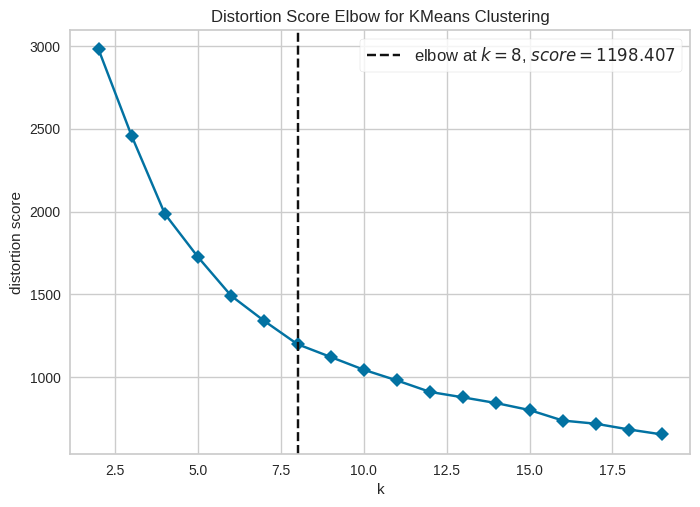

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='distortion', timings=False, random_state=42
)

visualizer.fit(dir_model2_normalized)
visualizer.show()

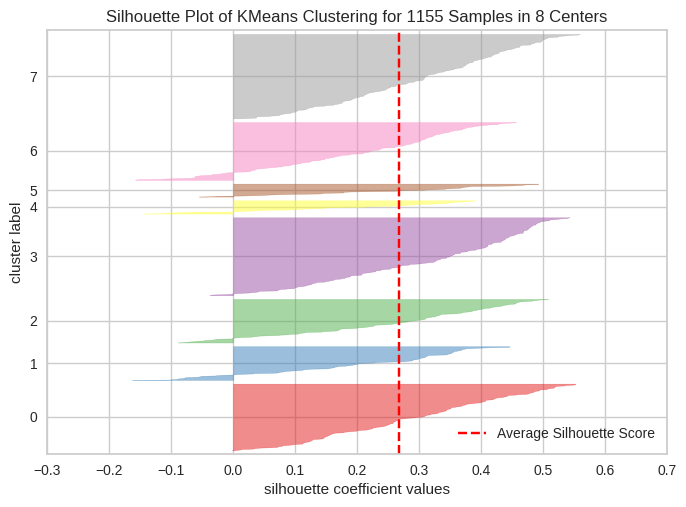

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1155 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
n_clusters_kmeans=8

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(dir_model2_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

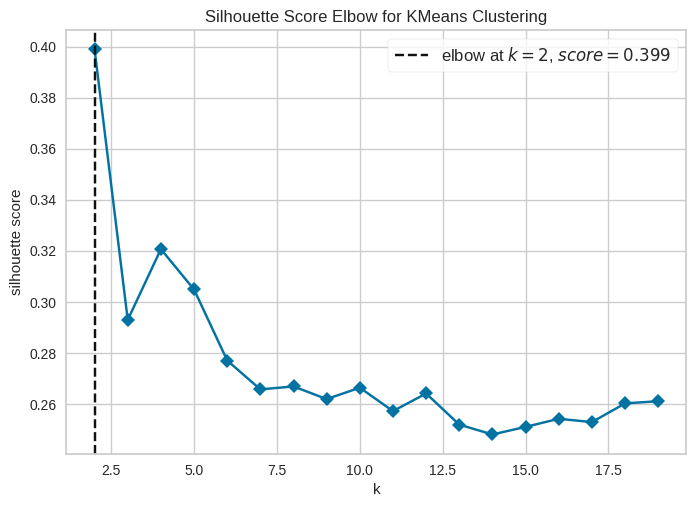

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='silhouette', timings=False, random_state=42
)

visualizer.fit(dir_model2_normalized)
visualizer.show()

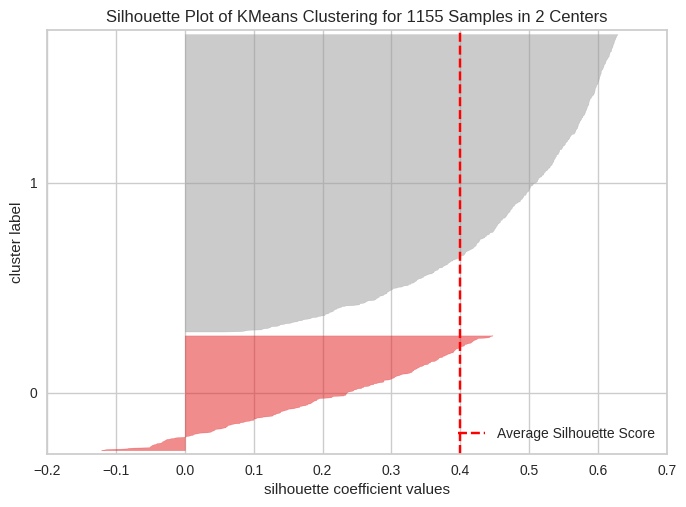

Average silhouette score: 0.39884309205935453


In [ ]:
n_clusters_kmeans=2

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(dir_model2_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

print("Average silhouette score:", visualizer.silhouette_score_)

# Model 3: Non-text + Actor Frequency + Director Frequency

In [ ]:
#build cluster matrix
all_cluster_model3 = age_gaps_copy[[
    "age_difference",
    "mean_age_of_couple",
    "relative_age_gap",
    "director_freq",
    "actor_freq_sum"
]]
all_cluster_model3

,age_difference,mean_age_of_couple,relative_age_gap,director_freq,actor_freq_sum
0,52,49.0,2.260870,1,2
1,50,49.0,2.083333,3,2
2,49,44.5,2.450000,2,3
3,45,45.5,1.956522,5,3
4,43,59.5,1.131579,2,3
...,...,...,...,...,...
1150,0,23.0,0.000000,4,12
1151,0,42.0,0.000000,1,34
1152,0,30.0,0.000000,1,5
1153,0,21.0,0.000000,6,3


In [ ]:
# Normalize df
all_model3_normalized = pd.DataFrame(sc.fit_transform(all_cluster_model3), columns=all_cluster_model3.columns)

all_model3_normalized

,age_difference,mean_age_of_couple,relative_age_gap,director_freq,actor_freq_sum
0,4.887011,1.693628,5.471972,-0.867634,-1.183765
1,4.651921,1.693628,4.956601,-0.313059,-1.183765
2,4.534377,1.132271,6.020999,-0.590346,-1.031102
3,4.064198,1.257017,4.588479,0.241516,-1.031102
4,3.829108,3.003460,2.193749,-0.590346,-1.031102
...,...,...,...,...,...
1150,-1.225315,-1.549765,-1.091117,-0.035771,0.342864
1151,-1.225315,0.820407,-1.091117,-0.867634,3.701446
1152,-1.225315,-0.676544,-1.091117,-0.867634,-0.725776
1153,-1.225315,-1.799257,-1.091117,0.518804,-1.031102


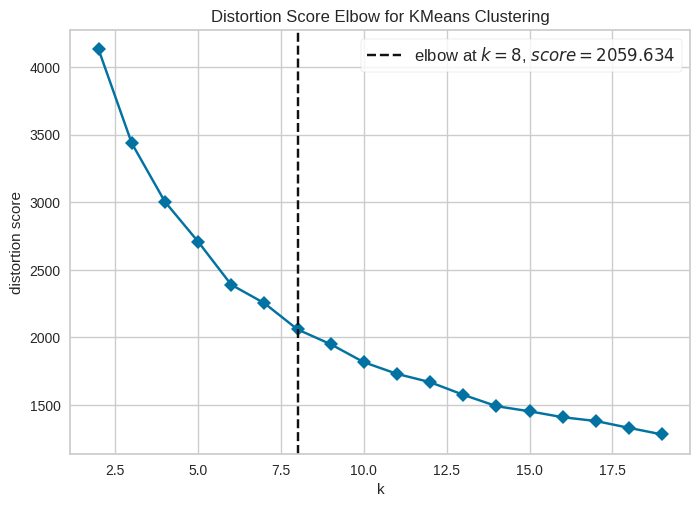

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='distortion', timings=False, random_state=42
)

visualizer.fit(all_model3_normalized)
visualizer.show()

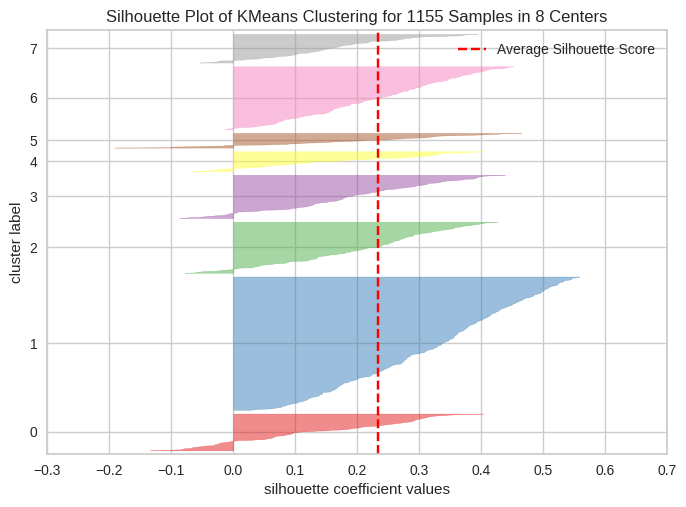

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1155 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
n_clusters_kmeans=8

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(all_model3_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

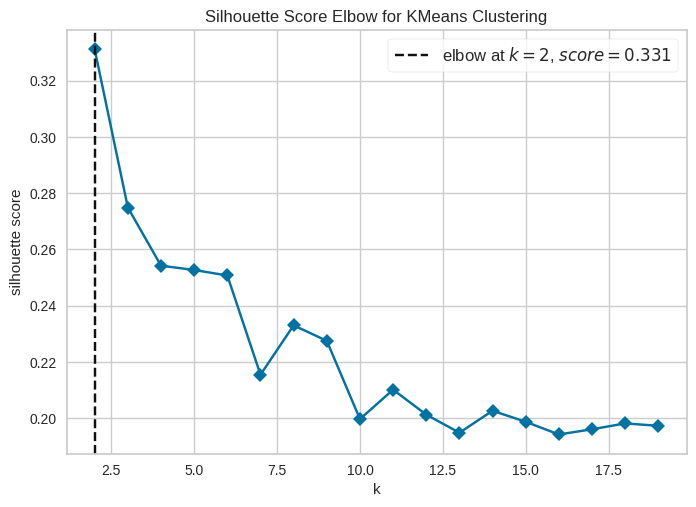

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='silhouette', timings=False, random_state=42
)

visualizer.fit(all_model3_normalized)
visualizer.show()

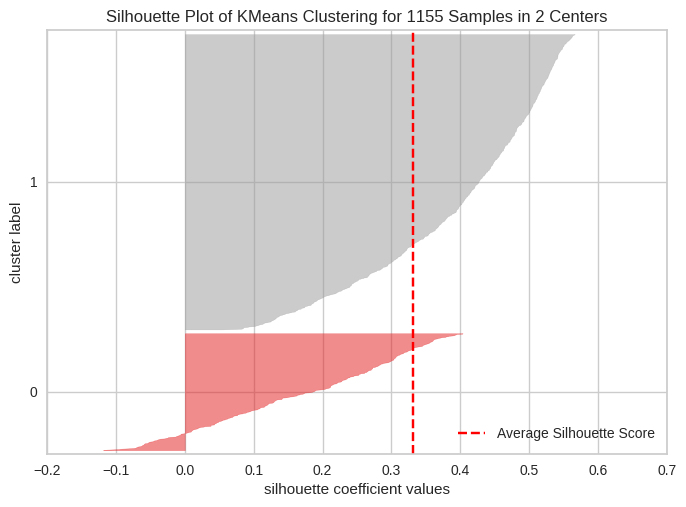

Average silhouette score: 0.33108448818683855


In [ ]:
n_clusters_kmeans=2

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(all_model3_normalized)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

print("Average silhouette score:", visualizer.silhouette_score_)

# Final Model: Model 0 Exploratory

In [ ]:
age_gap_copy_model0 = age_gaps_copy.copy()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
age_gap_copy_model0['cluster_labels'] = kmeans.fit_predict(dir_model0_normalized).astype(str)
age_gap_copy_model0['cluster_labels'].value_counts().sort_index()

,count
cluster_labels,
0,322
1,833


In [ ]:
age_gap_copy_model0.head()

,movie_name,release_year,director,age_difference,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_age,actor_2_age,...,actor_freq_sum,director_freq,younger_age,order_age,mean_age_of_couple,relative_age_gap,relationship_type,who_is_older,by_decade,cluster_labels
0,Harold and Maude,1971,Hal Ashby,52,Ruth Gordon,Bud Cort,woman,man,75,23,...,2,1,23,75,49.0,2.260870,Heterosexual,woman,1970,0
1,Venus,2006,Roger Michell,50,Peter O'Toole,Jodie Whittaker,man,woman,74,24,...,2,3,24,74,49.0,2.083333,Heterosexual,man,2000,0
2,The Quiet American,2002,Phillip Noyce,49,Michael Caine,Do Thi Hai Yen,man,woman,69,20,...,3,2,20,69,44.5,2.450000,Heterosexual,man,2000,0
3,The Big Lebowski,1998,Joel Coen,45,David Huddleston,Tara Reid,man,woman,68,23,...,3,5,23,68,45.5,1.956522,Heterosexual,man,1990,0
4,Beginners,2010,Mike Mills,43,Christopher Plummer,Goran Visnjic,man,man,81,38,...,3,2,38,81,59.5,1.131579,Same-gender,Same-gender,2010,0


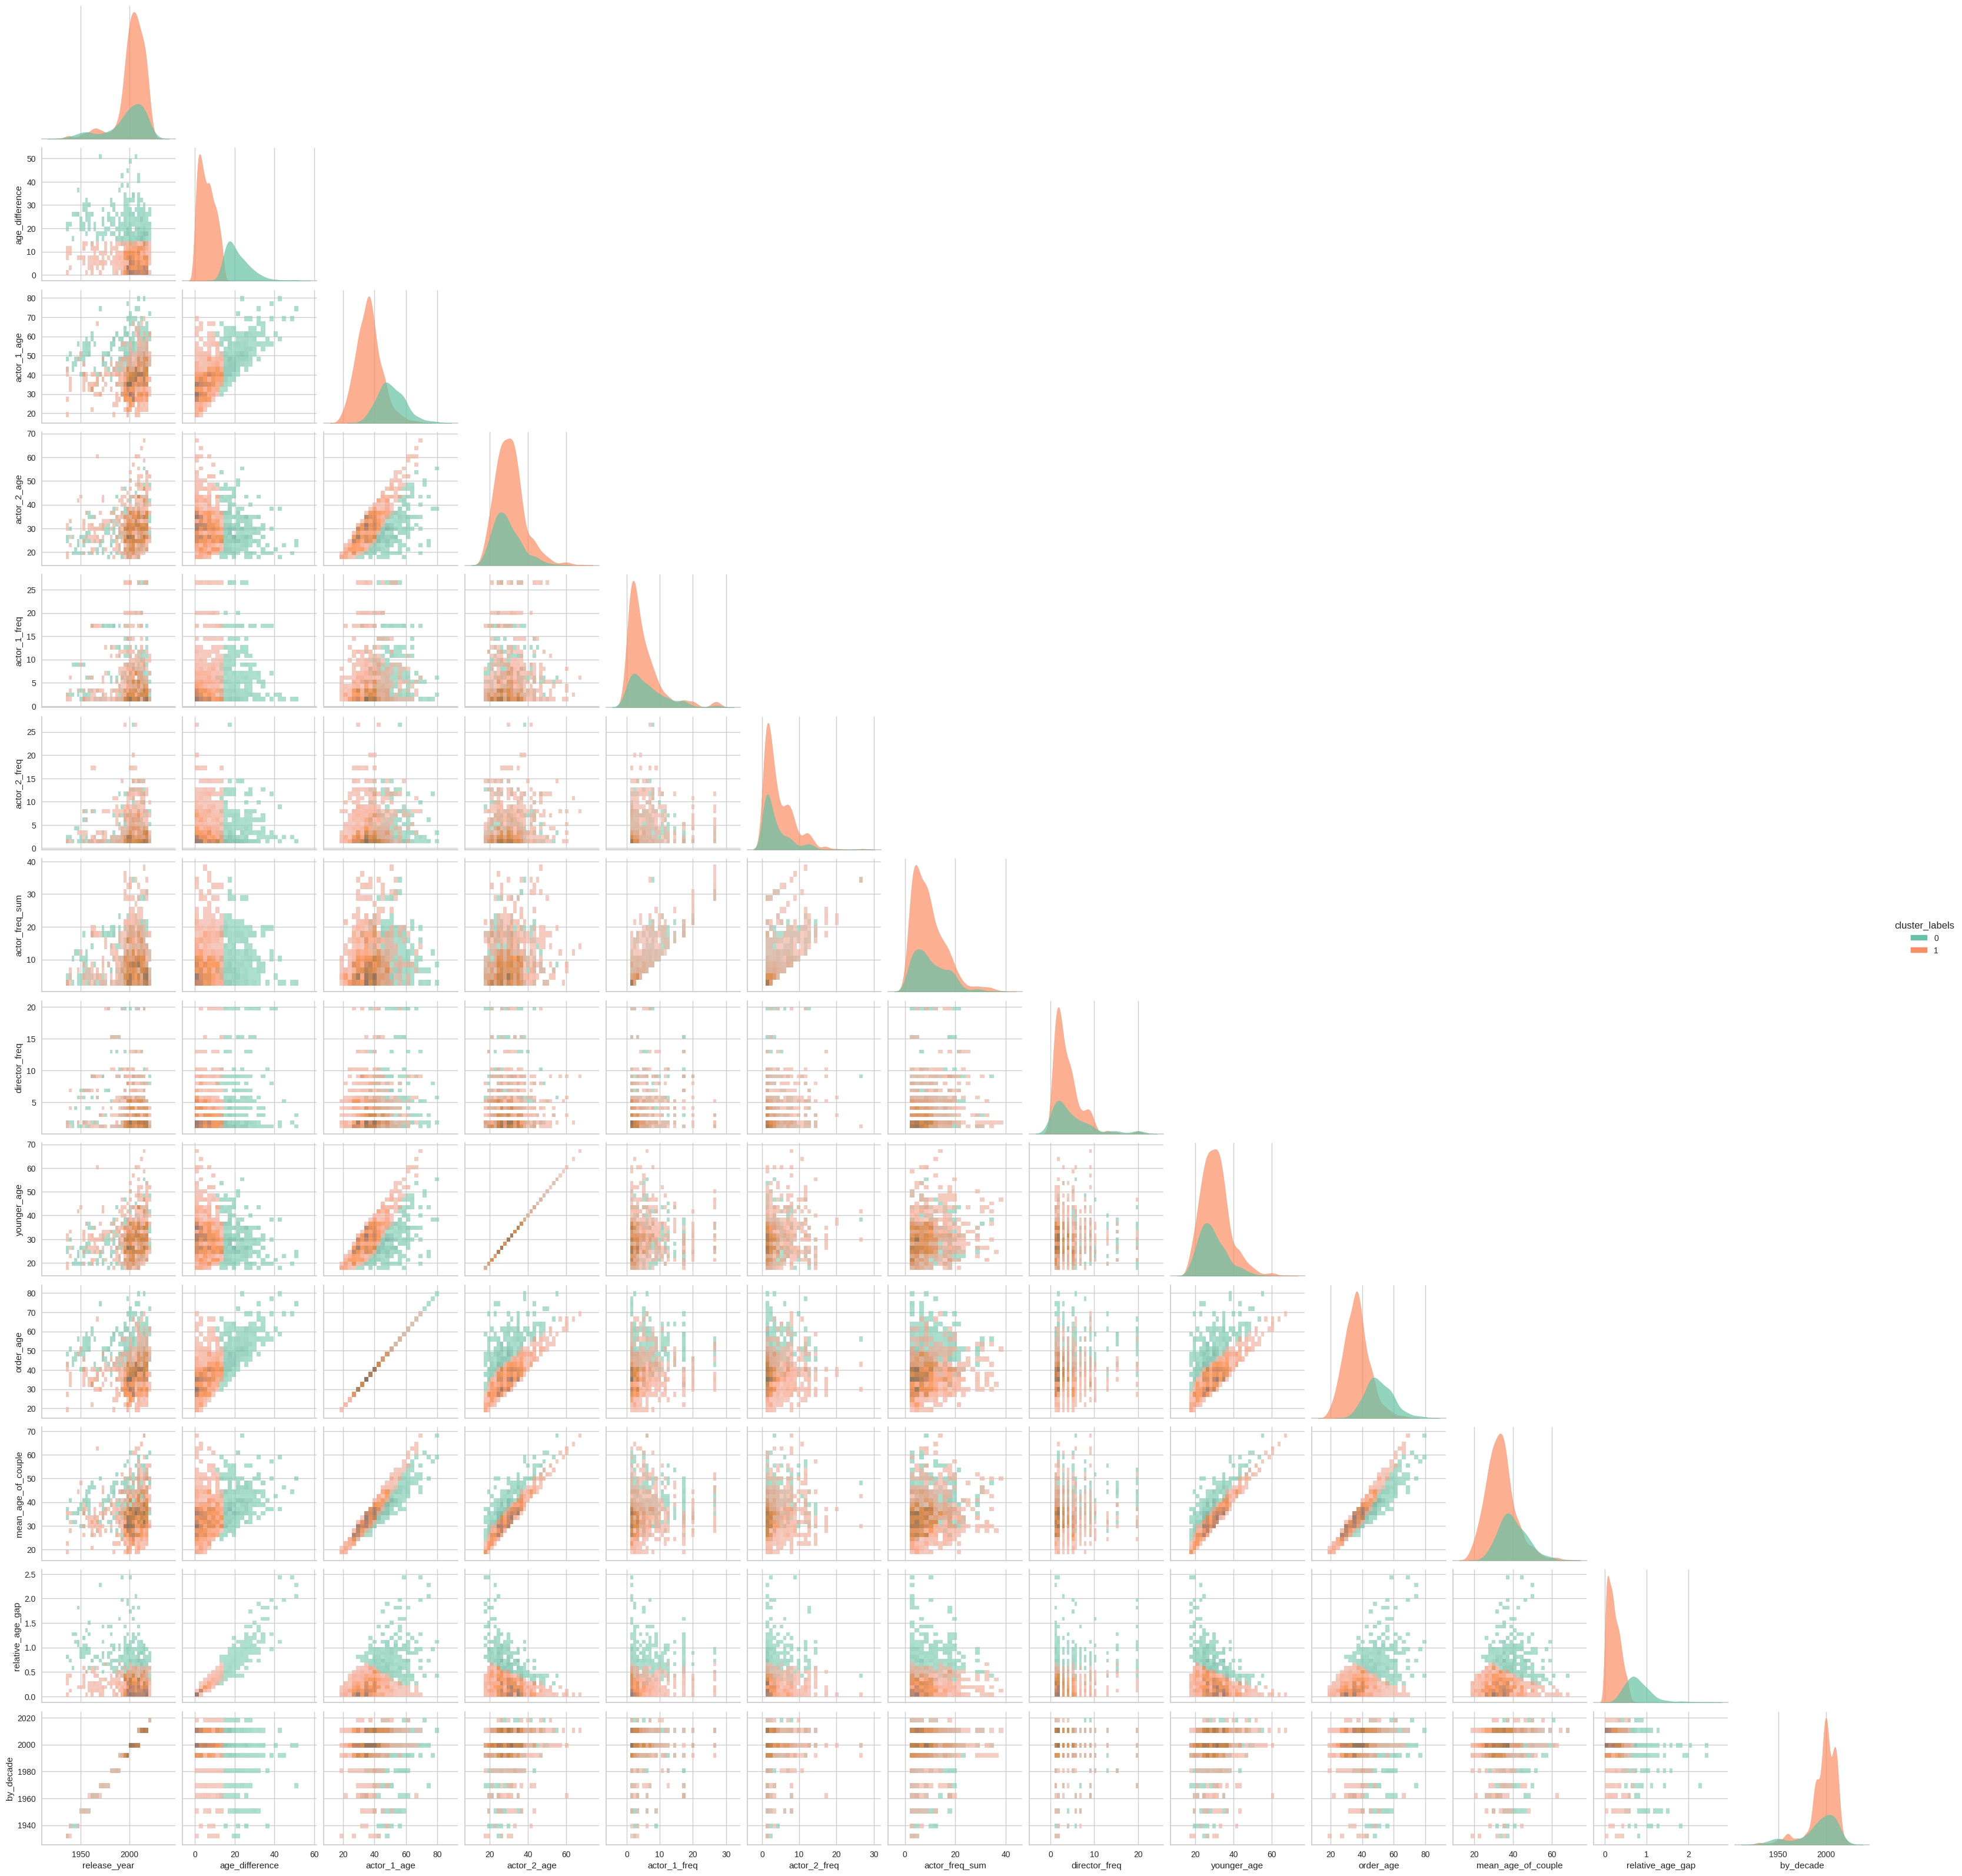

In [ ]:
sns.pairplot(age_gap_copy_model0, hue="cluster_labels", kind="hist", diag_kind="kde", corner=True, palette="Set2",
    plot_kws={'alpha': 0.7}, # Adjusts transparency of the scatter points (0.0 to 1.0)
    diag_kws={'alpha': 0.7}  # Adjusts transparency of the diagonal plots (histograms/KDEs)
    )

In [ ]:
age_gap_copy_model0.groupby('cluster_labels')['mean_age_of_couple'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_labels,,,,,,,,
0,322.0,39.992236,7.256908,24.0,35.0,39.0,44.5,67.5
1,833.0,33.657263,7.595300,18.0,28.5,33.0,37.0,69.0


## Boxplot for Model 0

/tmp/ipython-input-2127057375.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=age_gap_copy_model0, x='cluster_labels', y="mean_age_of_couple", palette="Set2")


<Axes: xlabel='cluster_labels', ylabel='mean_age_of_couple'>

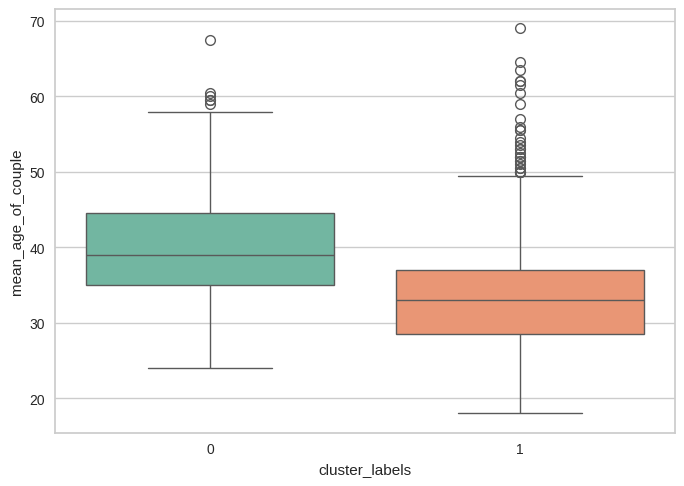

In [ ]:
sns.boxplot(data=age_gap_copy_model0, x='cluster_labels', y="mean_age_of_couple", palette="Set2")

In [ ]:
age_gap_copy_model0.groupby('cluster_labels')['relationship_type'].value_counts()

cluster_labels  relationship_type
0               Heterosexual         313
                Same-gender            9
1               Heterosexual         819
                Same-gender           14
Name: count, dtype: int64

In [ ]:
age_gap_copy_model0.groupby('cluster_labels')['who_is_older'].value_counts()

cluster_labels  who_is_older
0               man             299
                woman            14
                Same-gender       9
1               man             618
                woman           171
                same_age         30
                Same-gender      14
Name: count, dtype: int64

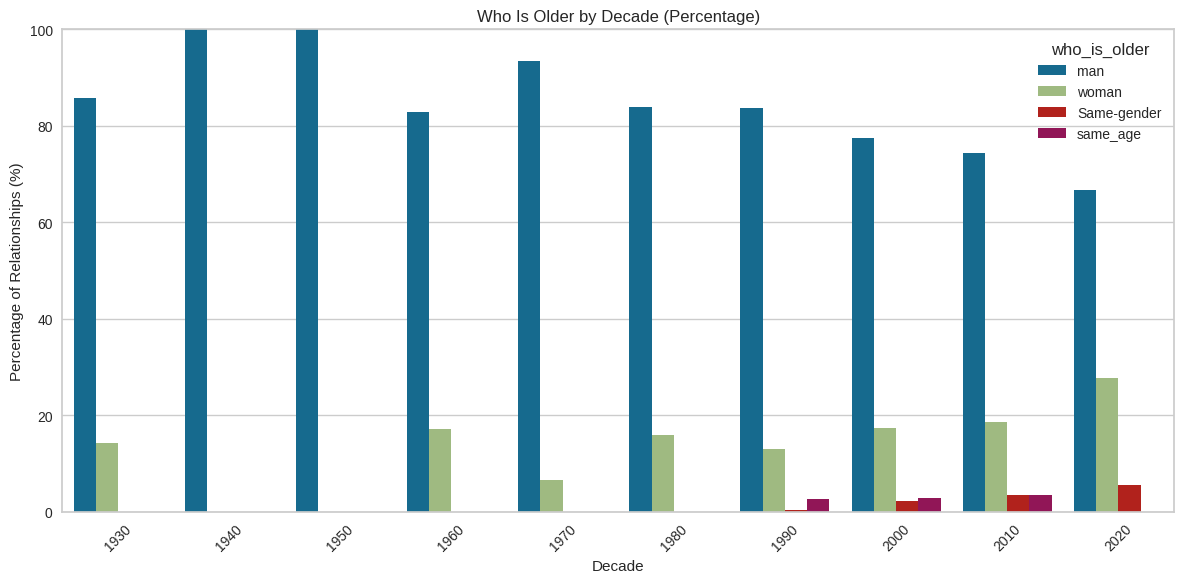

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

decade_order_counts = (
    age_gap_copy_model0
    .groupby(['by_decade', 'who_is_older'])
    .size()
    .reset_index(name='count')
)

decade_totals = (
    decade_order_counts
    .groupby('by_decade')['count']
    .sum()
    .reset_index(name='total')
)
decade_order_pct = decade_order_counts.merge(
    decade_totals,
    on='by_decade'
)

decade_order_pct['percentage'] = (
    decade_order_pct['count'] / decade_order_pct['total'] * 100
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=decade_order_pct,
    x='by_decade',
    y='percentage',
    hue='who_is_older'
)

plt.xlabel('Decade')
plt.ylabel('Percentage of Relationships (%)')
plt.title('Who Is Older by Decade (Percentage)')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


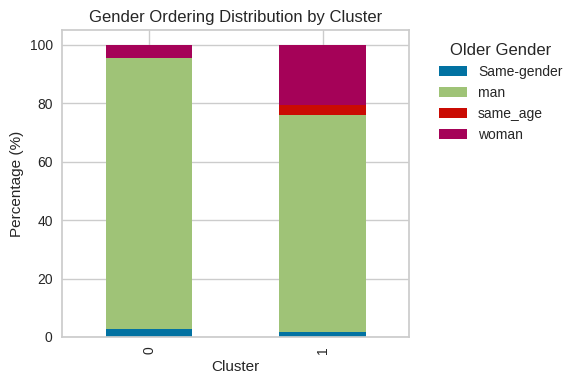

In [ ]:
import matplotlib.pyplot as plt

gender_pct = (
    pd.crosstab(age_gap_copy_model0['cluster_labels'], age_gap_copy_model0['who_is_older'], normalize='index')
    * 100
)

gender_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4)
)

plt.ylabel('Percentage (%)')
plt.xlabel('Cluster')
plt.title('Gender Ordering Distribution by Cluster')
plt.legend(title='Older Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Boxplot for Model 3

In [ ]:
age_gap_copy_model3 = age_gaps_copy.copy()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
age_gap_copy_model3['cluster_labels'] = kmeans.fit_predict(all_model3_normalized).astype(str)
age_gap_copy_model3['cluster_labels'].value_counts().sort_index()

,count
cluster_labels,
0,328
1,827


/tmp/ipython-input-236037097.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=age_gap_copy_model3, x='cluster_labels', y="mean_age_of_couple", palette="Set2")


<Axes: xlabel='cluster_labels', ylabel='mean_age_of_couple'>

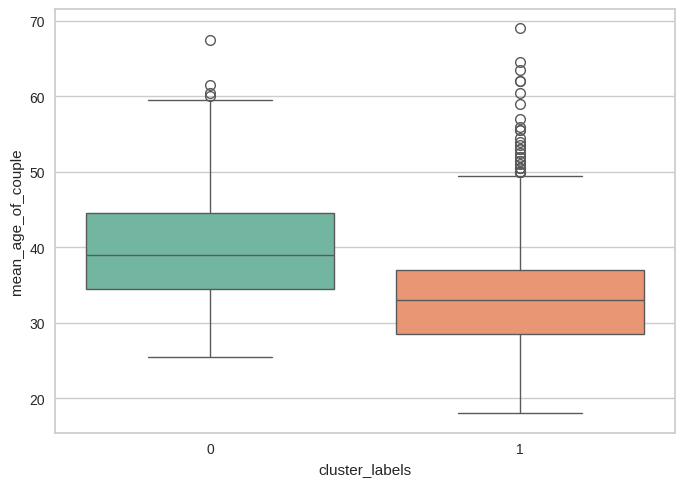

In [ ]:
sns.boxplot(data=age_gap_copy_model3, x='cluster_labels', y="mean_age_of_couple", palette="Set2")

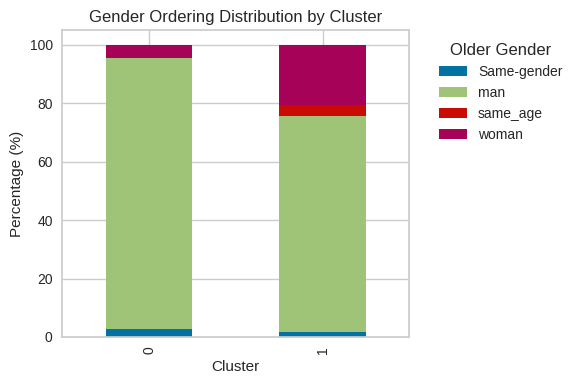

In [ ]:
import matplotlib.pyplot as plt

gender_pct = (
    pd.crosstab(age_gap_copy_model3['cluster_labels'], age_gap_copy_model3['who_is_older'], normalize='index')
    * 100
)

gender_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4)
)

plt.ylabel('Percentage (%)')
plt.xlabel('Cluster')
plt.title('Gender Ordering Distribution by Cluster')
plt.legend(title='Older Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()